In [19]:
#------------------------------------------------------------------------------
# Project 1
# Written by: Harsh Deep Kour(40082906) and Iknoor Singh Arora(40082312)
# For COMP 6721 Section: FK (1779) - Fall 2019
#------------------------------------------------------------------------------

import geopandas as gp
import numpy as np
import pandas as pd 
from shapely.geometry import Polygon
from shapely.geometry import LineString,shape,Point
import matplotlib.pyplot as plt
import math
import time


#file =r"/Users/harshkour/Downloads/Shape/crime_dt.shp"
file =r"Shape/crime_dt.shp"

filedata = gp.read_file(file)

#xmin=-73.59
#ymin=45.49
#xmax=-73.55
#ymax=45.53

xmin,ymin,xmax,ymax = filedata.geometry.total_bounds #get the boundary as start and end points of the grid

length_value = input("Please enter the length of the block: ")
wide_value = input("Please enter the width of the block: ")
threshold_value = input("Please enter the Threshold: ")
heuristic = int(input("Enter the heuristic function type (0: Distance and 1:Cost & Distance)"))
algo_type = int(input("Enter the Algorithm type (0: A* and 1: BFS)"))

length = float(length_value)
wide = float(wide_value)


cols = np.arange(xmin, xmax, wide)
rows = np.arange(ymin, ymax, length)

height = 0
width = 0
polygons = []
polygon_left_dic = {}
polypoint_dic = {} # dictionary with all 4 co-ordinates with key as polygon_Id
polyno = 0
for x in cols:
    for y in rows:
        polygon_ends= []
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]) )
        polygon_ends.extend(((x,y), (x+wide, y), (x+wide, y+length), (x, y+length))) 
        polypoint_dic[polyno] = polygon_ends
        polygon_left_dic[polyno] = (x,y)
        polyno = polyno + 1
        if x == xmin:
            height = height + 1
        if y == ymin:
            width = width + 1
    
grid = gp.GeoDataFrame({'geometry':polygons})
grid.to_file("Shape/grid.shp") #polygons written to shape file to avoid data storage                                     

#file2 = r"/Users/harshkour/Downloads/Shape/grid.shp"
file2 = r"Shape/grid.shp"
file1 = gp.read_file(file2) # read the shape file of polygons


Please enter the length of the block: 0.002
Please enter the width of the block: 0.002
Please enter the Threshold: 50
Enter the heuristic function type (0: Distance and 1:Cost & Distance)0
Enter the Algorithm type (0: A* and 1: BFS)0


In [20]:
points = gp.GeoDataFrame.from_file(file) 
polygs = gp.GeoDataFrame.from_file(file2) 
polygs.crs = {'init' :'epsg:4326'}
no_of_polygons = len(polygs)
pointInPoly = gp.sjoin(points, polygs,how='left') 

In [21]:
dict = {}
#make dictionary for polygon_no:no. of points in that polygon to avoid multiple reads from the Shape file
row_iterator = pointInPoly.iterrows()
for i, row in row_iterator:
    Float_id = row['FID'] 
    if Float_id in dict.keys():
        num_inc = dict[Float_id] + 1
        dict[Float_id] = num_inc
    else:
        dict[Float_id] = 1

In [22]:
point = []
# for each polygon, append the no. of points into the list point[] to be used for mean/median/standard deviation
# calculations
for i in range (0, no_of_polygons):
    if i in dict.keys():
        point.append(dict[i])
    else:
        point.append(0)

point.sort(reverse = True) # Sort the list in decreasing order to calculate the Median

In [23]:
# Calculate Mean, Median and Standard Deviation
mean = np.mean(point)
median = np.median(point)
standard_dev = np.std(point)


In [24]:
color = [] # list to write the shape file containg polygons in order to plot the dataframe
color_dic = {} #dictionary with color at key as polygon Id
threshold = int(threshold_value)
polys_iterator = polygs.iterrows()
blocks_no = (no_of_polygons * (100-threshold))/100 
block_no = int(round(blocks_no)) - 1 # calculate no of blocks which should be yellow
value_block = point[block_no] # threshold value of no_of_points, above which the polygon will be yellow
for i, row in polys_iterator: 
    if i in dict.keys():
        if dict[i] >= value_block:
            color_dic[i] = 'yellow'
            color.append('yellow')
        else: 
            color_dic[i] = 'blue'
            color.append('blue')
    else:
        color_dic[i] = 'blue'
        color.append('blue')
color_dic[-1] = 'orange'

Mean:  47.525
Median: 35.0
Standard Deviation: 47.7950245841552


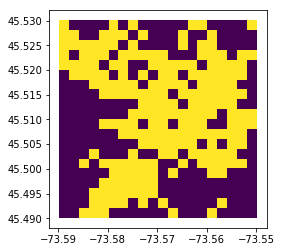

In [25]:
polygrid = gp.GeoDataFrame({'geometry':polygons, 'colors':color})
#polygrid.to_file("/Users/harshkour/Downloads/Shape/polygrid.shp") #write the color_of_polygons into shape file
polygrid.to_file("Shape/polygrid.shp") #write the color_of_polygons into shape file

#file3 = r"/Users/harshkour/Downloads/Shape/polygrid.shp"
file3 = r"Shape/polygrid.shp"
file4 = gp.read_file(file3)
polygrid.plot(column = 'colors', cmap = 'viridis')

print("Mean: " ,mean)
print("Median:", median)
print("Standard Deviation:", standard_dev)

In [26]:
startTime = time.time() #Initialize the start time to calculate the execution time of the algorithms
dict_neighbours = {} #dictionary to represent the graph nodes and the neighbour nodes
destination_key = 0 
start_key = 0

for key in range(0,no_of_polygons):
    d = -1
    l = -1 
    ul = -1
    dl = -1
    dr = -1
    u = -1
    r = -1
    ur = -1
    if key >=0 and key < height:
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr]
    elif (key%height) == 0:
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr]
    elif key == (height+1): #bottom-left
        u = key + 1
        r = key + height
        ur = key + height + 1
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr]
    elif key == ((2*height)-1): #top-left
        start_key = key
        d = key - 1 
        r = key + height
        dr = key + height - 1 #was lr earlier
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr]
    elif  key == (no_of_polygons - 1): #top-right  
        l = key-height
        dl = l-1 #was ld earlier
        d = key - 1
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr]
    elif  key == ((no_of_polygons - height)+1) : #bottom-right 
        destination_key = key
        u = key + 1
        l = key - height
        #ul = l - height + 1 #lu earlier
        ul= l+1
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr]
    elif key > (height + 1) and key < ((2*height)-1): #left corner row 
        u = key +1
        r = key +height
        ur = r + 1
        dr = r - 1 #lr earlier
        d = key -1
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr]
    elif key > (no_of_polygons - height + 1) and key < (no_of_polygons - 1): #right corner row
        #print("right corner row" , key)
        u = key + 1
        d = key - 1
        l = key -height
        ul = l+1
        dl = l-1
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr]     
    elif ((key-1)%height) == 0 and key > (height +1) and key < ((no_of_polygons - height)+2) : #down corner row
        u = key + 1
        l = key - height
        r =key + height
        ul = l+1
        ur = r+1
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr] 
    elif ((key+1)%height) == 0 and key > ((2*height)-1) and key < (no_of_polygons - 1): #upper corner row   
        #print("upper row key", key)
        d = key - 1
        l = key - height
        r = key + height
        #print("r is", r)
        dl = l - 1 #ld earlier
        dr = r - 1 #rd earlier
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr] 
    else:
        u = key + 1
        d = key - 1
        l = key - height
        r = key + height
        ul = l + 1
        ur = r + 1
        dl = l -1
        dr = r - 1
        dict_neighbours[key] = [u,d,l,r,ul,ur,dl,dr]

In [27]:
dict_cost = {} # intiatilize the dictionary to store the travel cost frome one node to the neighbours
for i in dict_neighbours.keys():
    cost = []
    neighbours = dict_neighbours[i]
    if neighbours[0] != -1 and ((color_dic[neighbours[2]]) == 'blue' or color_dic[i] == 'blue')  : # go up and l-color/self-color
        if (color_dic[neighbours[2]]) == 'blue' and (color_dic[i] == 'blue'):
            cost.append(1)
        else:
            cost.append(1.3)
    else:
        cost.append(-1)
    if neighbours[1] != -1 and ((color_dic[neighbours[1]]) == 'blue' or (color_dic[neighbours[6]]) == 'blue'): # go down and  d-color/dl-color
        if (color_dic[neighbours[1]]) == 'blue' and (color_dic[neighbours[6]] == 'blue'):
            cost.append(1)
        else:
            cost.append(1.3)
    else:
        cost.append(-1)
        
    if neighbours[2] != -1 and ((color_dic[neighbours[2]]) == 'blue' or (color_dic[neighbours[6]]) == 'blue'): #go left and l-color/dl-color
        if (color_dic[neighbours[2]]) == 'blue' and (color_dic[neighbours[6]] == 'blue'):
            cost.append(1)
        else:
            cost.append(1.3)
    else:
        cost.append(-1)
        
    if neighbours[3] != -1 and ((color_dic[neighbours[1]]) == 'blue' or (color_dic[i] == 'blue')): # go right and d-color/self-color
        #if (color_dic[neighbours[2]]) == 'blue' and (color_dic[neighbours[6]] == 'blue'):
        if (color_dic[neighbours[1]]) == 'blue' and (color_dic[i] == 'blue'):
            cost.append(1)
        else:
            cost.append(1.3)
    else:
        cost.append(-1)
                                
    if neighbours[4] != -1 and ((color_dic[neighbours[2]]) == 'blue'): #go upper-left and left color
        cost.append(1.5)
    else:
        cost.append(-1) 
    
    if neighbours[5] != -1 and (color_dic[i] == 'blue'): #go upper-right and self color
        cost.append(1.5)
    else:
        cost.append(-1)
    
    if neighbours[6] != -1 and ((color_dic[neighbours[6]]) == 'blue'): #go down-left and down-left color
        cost.append(1.5)
    else:
        cost.append(-1)
    
    if neighbours[7] != -1 and ((color_dic[neighbours[1]]) == 'blue'): #go down-right and down color
        cost.append(1.5)
    else:
        cost.append(-1)

    dict_cost[i] = cost

In [28]:
if heuristic == 0:
    new_heuristic = False
else:
    new_heuristic = True

In [29]:

heuristic_dict = {}
(d_lat,d_long) = polygon_left_dic[destination_key]

for key in polygon_left_dic.keys():
    (p_lat,p_long) = polygon_left_dic[key]
    h_lat = abs(p_lat - d_lat)
    h_long = abs(p_long - d_long)
    h_value = max(h_lat, h_long)
    heuristic_dict[key] = h_value

In [30]:
if new_heuristic:
    diagonal_cost = 1.5
    diagonal = math.sqrt(2) * length
    print(diagonal)
    for y in heuristic_dict.keys():
        val0 = heuristic_dict[y]
        val1 = (val0/diagonal) * diagonal_cost
        heuristic_dict[y] = val1

In [31]:
algo = algo_type #for A* = 0 and for bfs = 1

In [32]:
if algo == 0: # to execute A* algorithm
    travel_dict_f = {} #dictionary to store f(n) of each node
    travel_dict_g={} #dictionary to store g(n) of each node
    travel_dict_g[start_key]=0
    path=[]
    closed_list=[]
    open_list = [start_key] #initialize the open_list to enter the while loop for the first time
    travel_dict_f[start_key] = heuristic_dict[start_key]
    next = 0
    path_dict = {}
    path_found = False
    while(len(open_list) != 0): #execute the while loop until every node is checked for the path
        value_min = 999999999999 #intialize to the largest value to find the minimum f(n) from open_list
        for j in range (0,len(open_list)):
            key = open_list[j]
            value_f = travel_dict_f[key]
            if value_f < value_min:
                next = key
                value_min = value_f
    
        if next == destination_key: 
            path_found = True #set the path found variable to be used for cost calculation
            val = destination_key
            path.append(val)
            while val in path_dict.keys(): #Get the path using parent-child node traversal
                val = path_dict[val]
                path.append(val)
            open_list.clear() #path found
        else: # if destination not found, iterate the neighbours to check the possible path
            open_list.remove(next) # remove the key from open_list to avoid the cycle in path
            closed_list.append(next)# add the key used to mantain the list of travelled nodes
        
            neighbours_list = dict_neighbours[next]
            neighbour_cost = dict_cost[next]
       
            for i in range(0,len(neighbours_list)):
                neighbour = neighbours_list[i] #find the list of neighbours of next node
                neighbour_c = neighbour_cost[i] #find the cost of traversal of neighbours of next node 
                           
                if(neighbour!=-1) and (neighbour_c!=-1) and (neighbour not in closed_list):
                    parent = next              
                    neigh_g = neighbour_cost[i] + travel_dict_g[parent] # calculate the new g(n)
                    neigh_f = heuristic_dict[neighbour] + neigh_g
                    if neighbour not in open_list: #append the neighbour in the open_list for the potential next nodes
                        open_list.append(neighbour) 
                        travel_dict_g[neighbour] = neigh_g 
                        travel_dict_f[neighbour] = neigh_f
                        path_dict[neighbour] = parent 
                    else:
                        if travel_dict_g[neighbour] > neigh_g : # update the latest g(n), f(n) and parent
                            path_dict[neighbour] = parent
                            travel_dict_g[neighbour] = neigh_g
                            travel_dict_f[neighbour] = neigh_f

    endTime = time.time()

In [33]:
if algo == 1:   
    queue_list=[(start_key,heuristic_dict[start_key])] #initialize the queue_list with tuple (start_key, heuristic_distance)
    path_dict={}
    closed_list=[start_key] 
    path=[]
    path_found = False 
    neigb_dict_cost={}
    neigb_dict_cost[start_key]=0
    cost=0   
    while(len(queue_list)!=0): #execute the while loop until every node is checked for the path 
    
        if queue_list[0][0]==destination_key: #if path is found initialize path_found variable     
            path_found = True
            print("path found")
            val = destination_key
            path.append(val)
            while val in path_dict.keys():  #Get the path using parent-child node traversal  
                (val,costval) = path_dict[val]
                path.append(val)
                cost=cost+costval
            queue_list.clear()  
        else:    # if destination not found, iterate the neighbours to check the possible path
            (next,next_value)=queue_list.pop(0) # remove the first key from queue_list to explore its neighbours   
            neighbours_list=dict_neighbours[next] #find the list of neighbours of next node
            neighbour_cost=dict_cost[next] #find the cost of traversal of neighbours of next node 
        
            for i in range(0,len(neighbours_list)):
                neighbour = neighbours_list[i]
                neighbour_c = neighbour_cost[i]
            
                if(neighbour!=-1) and (neighbour_c!=-1) and (neighbour not in closed_list):
                
                    tup_list=(neighbour,neighbour_c+heuristic_dict[next])   #calculate the heuristic cost & edge cost  
                    queue_list.append(tup_list) #add the neighbour to the queue_list for potential next nodes
                    closed_list.append(neighbour) #append neighbour to closed_list to avoid traversing the node again
                    path_dict[neighbour]=(next,neighbour_c) #record the parent of the neighbour node
           
            queue_list = sorted(queue_list, key=lambda tup: tup[1]) #sort the open_list to get the minimum cost for next node       
    endTime = time.time()

In [34]:
start_polygon = height -1
last_polygon = no_of_polygons - height
if color_dic[start_polygon] == 'yellow' or color_dic[last_polygon] == 'yellow' :
    path_found = False

In [35]:
if path_found:
    #print("\n\npath", path)
    second_last_polygon = path[0]
    if algo == 0:
        Final_cost = travel_dict_g[second_last_polygon] + 3 # add 3 for two diagonals of sorce and target polygons
    elif algo == 1: 
        Final_cost = cost + 3 # add 3 for two diagonals of sorce and target polygons

    list = []
    first0 = 0
    first1 = 0

    last0 = 0
    last1 = 0

    list_final = []

    for m in range(0, (len(path))-1): #append the LineString's to plot the path lines on the graph
        first = path[m]
        second = path[m+1]
        (first_p1,first_p2) = polygon_left_dic[first]
        (second_p1,second_p2) = polygon_left_dic[second]
        if m == 0:
            (first0,first1) = (first_p1,first_p2)
        elif m == len(path)-1:
            (last0,last1) = (second_p1,second_p2)
        line = LineString([(first_p1,first_p2), (second_p1,second_p2)])
        list.append(LineString(line))

    yfinal0 = ymin + (height* length)
    xfinal0 = xmin + length
    line0 = LineString([(xmin,yfinal0), (xmin+length,yfinal0-length)]) 
    list_final.append(LineString(line0)) #append the diagonal of source polygon
    for h in range (0,len(list)):
        list_final.append(LineString(list[h]))

    xfinal1 = xmin + length*width
    yfinal1 = ymin + length    
    line1 = LineString([(xfinal1-length,yfinal1), (xfinal1,ymin)])
    list_final.append(LineString(line1)) #append the diagonal of target polygon

    polygrid = gp.GeoDataFrame({'geometry':polygons,'colors':color})
    poly22 = gp.GeoDataFrame(geometry=list_final)
    f, ax = plt.subplots()
    polygrid.plot(ax=ax, column = 'colors', cmap = 'viridis')
    poly22.plot(ax=ax, color='red')
    plt.show()

    print("Cost is ", Final_cost)
    execTime = endTime - startTime
    print("Execution time is ", execTime)
else:
    print("No path can be found")
print("Program is now Terminated!")

No path can be found
Program is now Terminated!
